In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import os.path
from os import path
from importlib import reload

WANDB_enable = False
creds_path_ar = ["../credentials.ini","credentials.colab.ini"]
root_path = ""
data_path = ""

for creds_path in creds_path_ar:
  if path.exists(creds_path):
      config_parser = configparser.ConfigParser()
      config_parser.read(creds_path)
      root_path = config_parser['MAIN']["PATH_ROOT"]
      data_path = config_parser['MAIN']["PATH_DATA"]
      WANDB_enable = config_parser['MAIN']["WANDB_ENABLE"] == 'TRUE'
      ENV = config_parser['MAIN']["ENV"]
      break

if ENV=="COLAB":
  from google.colab import drive
  mount_path = '/content/gdrive/'
  drive.mount(mount_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [3]:
cd {root_path}

/content/gdrive/My Drive/WORK/ML/develop/MAFAT/sota-mafat-radar


In [113]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

from src.utils import experiment_utils as utils
from src.utils import boilerplate

from src.model_arch import arch_setup
from src.model_arch import base_base_model

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)


random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if torch.has_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

In [114]:
reload(base_base_model)
reload(arch_setup)


<module 'src.model_arch.arch_setup' from '/content/gdrive/My Drive/WORK/ML/develop/MAFAT/sota-mafat-radar/src/model_arch/arch_setup.py'>

In [5]:
train_x, train_y, val_x, val_y = boilerplate.classic_trainval(data_path)

Everything is setup correctly


## Implementation

In [119]:
train_set = arch_setup.DS(train_x,train_y)
val_set= arch_setup.DS(val_x,val_y)

train_loader=DataLoader(dataset= train_set, batch_size = 16, shuffle = True, num_workers = 2)
val_loader=DataLoader(dataset= val_set, batch_size = 16, shuffle = True, num_workers = 2)

In [120]:
def init_weights(m):
    if (type(m) == nn.Linear) | (type(m) == nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
        #m.bias.data.fill_(0.01)

model= base_base_model.base_base_model()
model.apply(init_weights)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


#TODO: implement the Glorot Normal
# init = tf.keras.initializers.GlorotNormal(seed = 0)

model.to(device)

base_base_model(
  (cn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (cn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=5760, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)

In [121]:
_ = arch_setup.train_epochs(train_loader,val_loader,model,criterion,optimizer,num_epochs= 10,train_y=train_y,val_y=val_y)

started training epoch no. 1
temp: 0.0
epoch : 0.0000, loss : 92.0910, auc : 0.9286, acc : 0.7707, val_loss : 10.7238, val_auc : 0.8504, val_acc : 0.4951, 
---------------------------

started training epoch no. 2
temp: 0.0
epoch : 1.0000, loss : 63.4079, auc : 0.9687, acc : 0.7442, val_loss : 12.3951, val_auc : 0.8933, val_acc : 0.5405, 
---------------------------

started training epoch no. 3
temp: 0.0
epoch : 2.0000, loss : 47.9388, auc : 0.9822, acc : 0.7543, val_loss : 8.2563, val_auc : 0.9166, val_acc : 0.4951, 
---------------------------

started training epoch no. 4
temp: 0.0
epoch : 3.0000, loss : 37.6947, auc : 0.9892, acc : 0.7500, val_loss : 13.6827, val_auc : 0.9143, val_acc : 0.5081, 
---------------------------

started training epoch no. 5
temp: 0.0
epoch : 4.0000, loss : 27.2677, auc : 0.9944, acc : 0.7503, val_loss : 8.8820, val_auc : 0.9191, val_acc : 0.5016, 
---------------------------

started training epoch no. 6
temp: 0.0
epoch : 5.0000, loss : 17.4956, auc : 

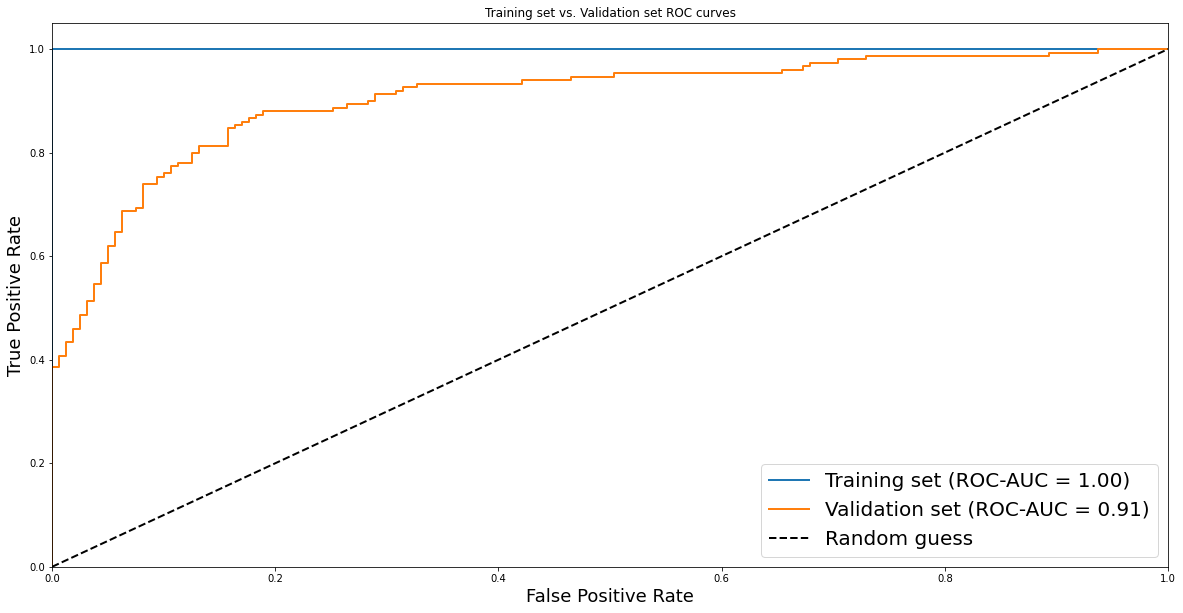

In [122]:
pred = [model(torch.from_numpy(train_x).to(device, dtype=torch.float)).detach().cpu().numpy(),
        model(torch.from_numpy(val_x).to(device, dtype=torch.float)).detach().cpu().numpy()]
actual = [train_y, val_y]
utils.stats(pred, actual)

In [85]:
train_y

array([0, 0, 0, ..., 1, 1, 1])

In [123]:
np.sum(arch_setup.thresh(model(torch.from_numpy(train_x).to(device, dtype=torch.float)).detach().cpu().numpy()))

974

In [124]:
np.sum(train_y)

970

In [93]:
model_output = model(torch.from_numpy(train_x).to(device, dtype=torch.float)).detach().cpu().numpy()
arch_setup.accuracy_calc(model_output,train_y)

0.9859926918392204